In [1]:
import numpy as np
import os,sys
from PIL import Image
from helpers import *
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from pylab import *

In [28]:
# Loaded a set of images

#root_dir = "augmented_training/"
root_dir = "training/"
image_dir = root_dir + "images/"
files = os.listdir(image_dir)  

n = 100

print("Loading " + str(n) + " satellite images")
imgs = [load_image(image_dir + files[i]) for i in range(n)] #List of each image Dim (100, 400,400,3)

gt_dir = root_dir + "groundtruth/"
files2 = os.listdir(gt_dir)

print("Loading " + str(n) + " groundtruth images")
gt_imgs = [load_image(gt_dir + files2[i]) for i in range(n)]
print('Image size = ' + str(imgs[0].shape[0]) + ',' + str(imgs[0].shape[1]))

Loading 100 satellite images
Loading 100 groundtruth images
Image size = 400,400


In [29]:
patch_size = 16 # each patch is 16*16 pixels  #400/16 = 25*25 = 625 patches for 10 images

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]   # dim img_patches = (n,625,16,16,3)
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches

img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])

print("img_patches:" + str(img_patches.shape))
print("gt_patches:" + str(gt_patches.shape))

img_patches:(62500, 16, 16, 3)
gt_patches:(62500, 16, 16)


In [30]:
def build_X_Y_classes(img_patches,gt_patches,foreground_threshold):
    
    X = np.asarray([extract_features(img_patches[i]) for i in range(len(img_patches))])
    Y = np.asarray([value_to_class(np.mean(gt_patches[i]),foreground_threshold) for i in range(len(gt_patches))])

    return X,Y

In [31]:
foreground_threshold = 0.25
X,Y = build_X_Y_classes(img_patches,gt_patches,foreground_threshold)
print(X.shape)
print(Y.shape)

(62500, 6)
(62500,)


In [32]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y,test_size=0.1)

In [65]:
model = Sequential()
model.add(Dense(512, input_dim=6, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [66]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [67]:
network_history = model.fit(X_train, Y_train,
          epochs=20,
          batch_size=128, validation_data=(X_val, Y_val))

Train on 56250 samples, validate on 6250 samples
Epoch 1/20
56250/56250 [==============================] - 8s 145us/step - loss: 0.5368 - acc: 0.7427 - val_loss: 0.5107 - val_acc: 0.7445
Epoch 2/20
56250/56250 [==============================] - 7s 127us/step - loss: 0.5135 - acc: 0.7525 - val_loss: 0.5074 - val_acc: 0.7571
Epoch 3/20
56250/56250 [==============================] - 7s 128us/step - loss: 0.5086 - acc: 0.7577 - val_loss: 0.5566 - val_acc: 0.7422
Epoch 4/20
56250/56250 [==============================] - 7s 126us/step - loss: 0.5019 - acc: 0.7593 - val_loss: 0.5078 - val_acc: 0.7549
Epoch 5/20
56250/56250 [==============================] - 7s 125us/step - loss: 0.4972 - acc: 0.7624 - val_loss: 0.4884 - val_acc: 0.7610
Epoch 6/20
56250/56250 [==============================] - 7s 128us/step - loss: 0.4917 - acc: 0.7647 - val_loss: 0.4789 - val_acc: 0.7768
Epoch 7/20
56250/56250 [==============================] - 7s 125us/step - loss: 0.4865 - acc: 0.7669 - val_loss: 0.5171 - v

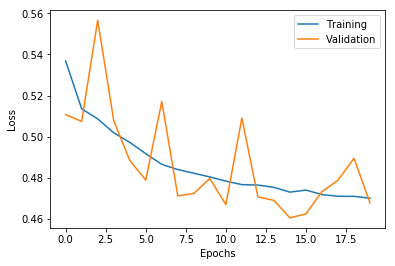

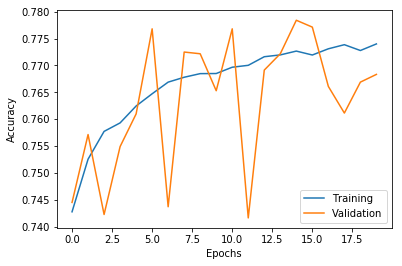

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(network_history):
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_history(network_history)

In [69]:
from sklearn.metrics import f1_score
score = model.evaluate(X_val, Y_val, batch_size=128)
print(score)

6250/6250 [==============================] - 0s 41us/step
[0.4677889961719513, 0.76832000007629397]


In [37]:
test_dir = 'test_set_images/'

imgs_test = load_test_images(test_dir) ##In helpers.py
patch_size = 16 

img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(len(imgs_test))]# dim img_patches
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])

print("img_patches:" + str(img_patches_test.shape))

data = np.asarray([extract_features(img_patches_test[i]) for i in range(len(img_patches_test))])
print('Dataset (RGB features Mean/Variance) :', data.shape)


Loading 50 test images
Size of image: 608,608
img_patches:(72200, 16, 16, 3)
Dataset (RGB features Mean/Variance) : (72200, 6)


In [44]:
y_pred = model.predict(data, batch_size = 128)

for i in range(len(y_pred)):
    
    if y_pred[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1


print('prediction_shape: before',y_pred.shape)
labels = np.reshape(y_pred,(50,1444))
print('prediction_shape: after',labels.shape) ##iterate over each image more easily

prediction_shape: before (72200, 1)
prediction_shape: after (50, 1444)


In [45]:
imgwidth = imgs_test[0].shape[0] 
imgheight = imgs_test[0].shape[1] 
w = patch_size
h = patch_size

os.makedirs('prediction_nn/', exist_ok=True) 

for i in range(len(labels)):
    im = label_to_img(imgwidth, imgheight, w, h, labels[i])
    im = img_float_to_uint8(im)
    Image.fromarray(im).save('prediction_nn/prediction_' + '%.3d' % (i + 1)+ '.png')